# 概要
https://qiita.com/kenmatsu4/items/dd9593edf282d44168d3
- Titanicdデータセットを使ってpystanの練習をする
- ロジスティック回帰を行う
- y =  ax_1 + bx_2 + .......

## 求めたいもの
- 切片/ 係数ベクトル

# ライブラリ準備

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib 
plt.style.use("ggplot")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns

from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

# 設定
import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

# データ

## 準備

In [2]:
titanic = pd.read_table("https://raw.githubusercontent.com/matsuken92/Qiita_Contents/master/PyStan-Titanic/data/titanic_converted.csv",
              sep=",", header=0)
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,1,22.0,1,0,7.2500,1,3,1,1,0,3,1
1,1,1,0,38.0,1,0,71.2833,2,1,2,0,3,1,0
2,1,3,0,26.0,0,0,7.9250,1,3,2,0,0,3,0
3,1,1,0,35.0,1,0,53.1000,1,1,2,0,3,3,0
4,0,3,1,35.0,0,0,8.0500,1,3,1,1,0,3,1
5,0,3,1,28.0,0,0,8.4583,3,3,1,1,0,2,1
6,0,1,1,54.0,0,0,51.8625,1,1,1,1,5,3,1
7,0,3,1,2.0,3,1,21.0750,1,3,0,0,0,3,0
8,1,3,0,27.0,0,2,11.1333,1,3,2,0,0,3,0
9,1,2,0,14.0,1,0,30.0708,2,2,0,0,0,1,0


## 分割

In [3]:
target = titanic.survived

data = titanic.iloc[:, 1:6]

In [4]:

# 訓練データ(80%), テストデータ(20%)に分割する
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

# stanで実行

## データの定義

In [5]:
dat = {'N': X_train.shape[0], 'M': X_train.shape[1], 'X': X_train, 'y': y_train}

## モデルの定義

In [6]:
code = """
        
        data {
            // N :データの個数
            int<lower=0> N;
            
            // 特徴量数
            int<lower=0> M;
            
            //　X:N*M行列の訓練データ
            matrix[N, M] X;
            
            //　教師データ
            int<lower=0, upper=1> y[N];
            
        } 
        
        //確率分布のパラメータなど、推定した変数の宣言を行う
        parameters {
            //　 切片
            real beta0;
            
            //回帰係数
            vector[M] beta; 
            
        } 
        
        //統計モデルの宣言
        model {
            for (i in 1:N)
                // dot_product（x, y）:x,yの内積を計算
                // inv_logit(y):標準のシグモイド関数
                // * y ~ bernoulli(theta):事後分布を計算
                
                y[i] ~ bernoulli(inv_logit (beta0 + dot_product(X[i] , beta)));
        }
        
        """

## モデルのコンパイル

In [7]:
# Build Stan model
%time stm = StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84c69f5cfc2a7c9e31d33f12dc18201a NOW.


CPU times: user 1.22 s, sys: 74.2 ms, total: 1.3 s
Wall time: 48.1 s


In [8]:
n_itr = 3000
n_warmup = 200
chains = 2

# サンプリングの実行
%time fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)

# サンプル列を抽出
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

CPU times: user 117 ms, sys: 34.9 ms, total: 152 ms
Wall time: 39.3 s


In [9]:
print(fit)

Inference for Stan model: anon_model_84c69f5cfc2a7c9e31d33f12dc18201a.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0     5.26    0.01   0.54   4.23   4.88   5.25   5.63   6.31   2319    1.0
beta[1]  -1.11  2.6e-3   0.13  -1.37  -1.21  -1.11  -1.02  -0.86   2623    1.0
beta[2]  -2.78  3.9e-3   0.22  -3.21  -2.92  -2.77  -2.63  -2.35   3247    1.0
beta[3]  -0.04  1.5e-4 8.8e-3  -0.06  -0.05  -0.04  -0.04  -0.03   3517    1.0
beta[4]   -0.4  2.0e-3   0.12  -0.65  -0.49   -0.4  -0.32  -0.17   3714    1.0
beta[5]  -0.05  2.2e-3   0.13  -0.32  -0.14  -0.05   0.03    0.2   3506    1.0
lp__    -322.3    0.03   1.67 -326.4 -323.2 -321.9 -321.0 -319.9   2474    1.0

Samples were drawn using NUTS at Thu Jan 10 19:20:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor 

In [10]:
# 各パラメーターのEAP推定量リスト抽出
mean_list = np.array(fit.summary()['summary'])[:,0]

In [11]:
# 各パラメーターのMAP推定量のリスト生成
ddd = la['beta0']
def find_MAP(data):
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 501)
    eval_kde = kde.evaluate(x_range)
    #plt.plot(x_range, eval_kde)
    return x_range[np.argmax(eval_kde)]

MAP_list = []
MAP_list.append(find_MAP(ddd))
for i in range(n_param-1):
    MAP_list.append(find_MAP(la['beta'][:,i]))

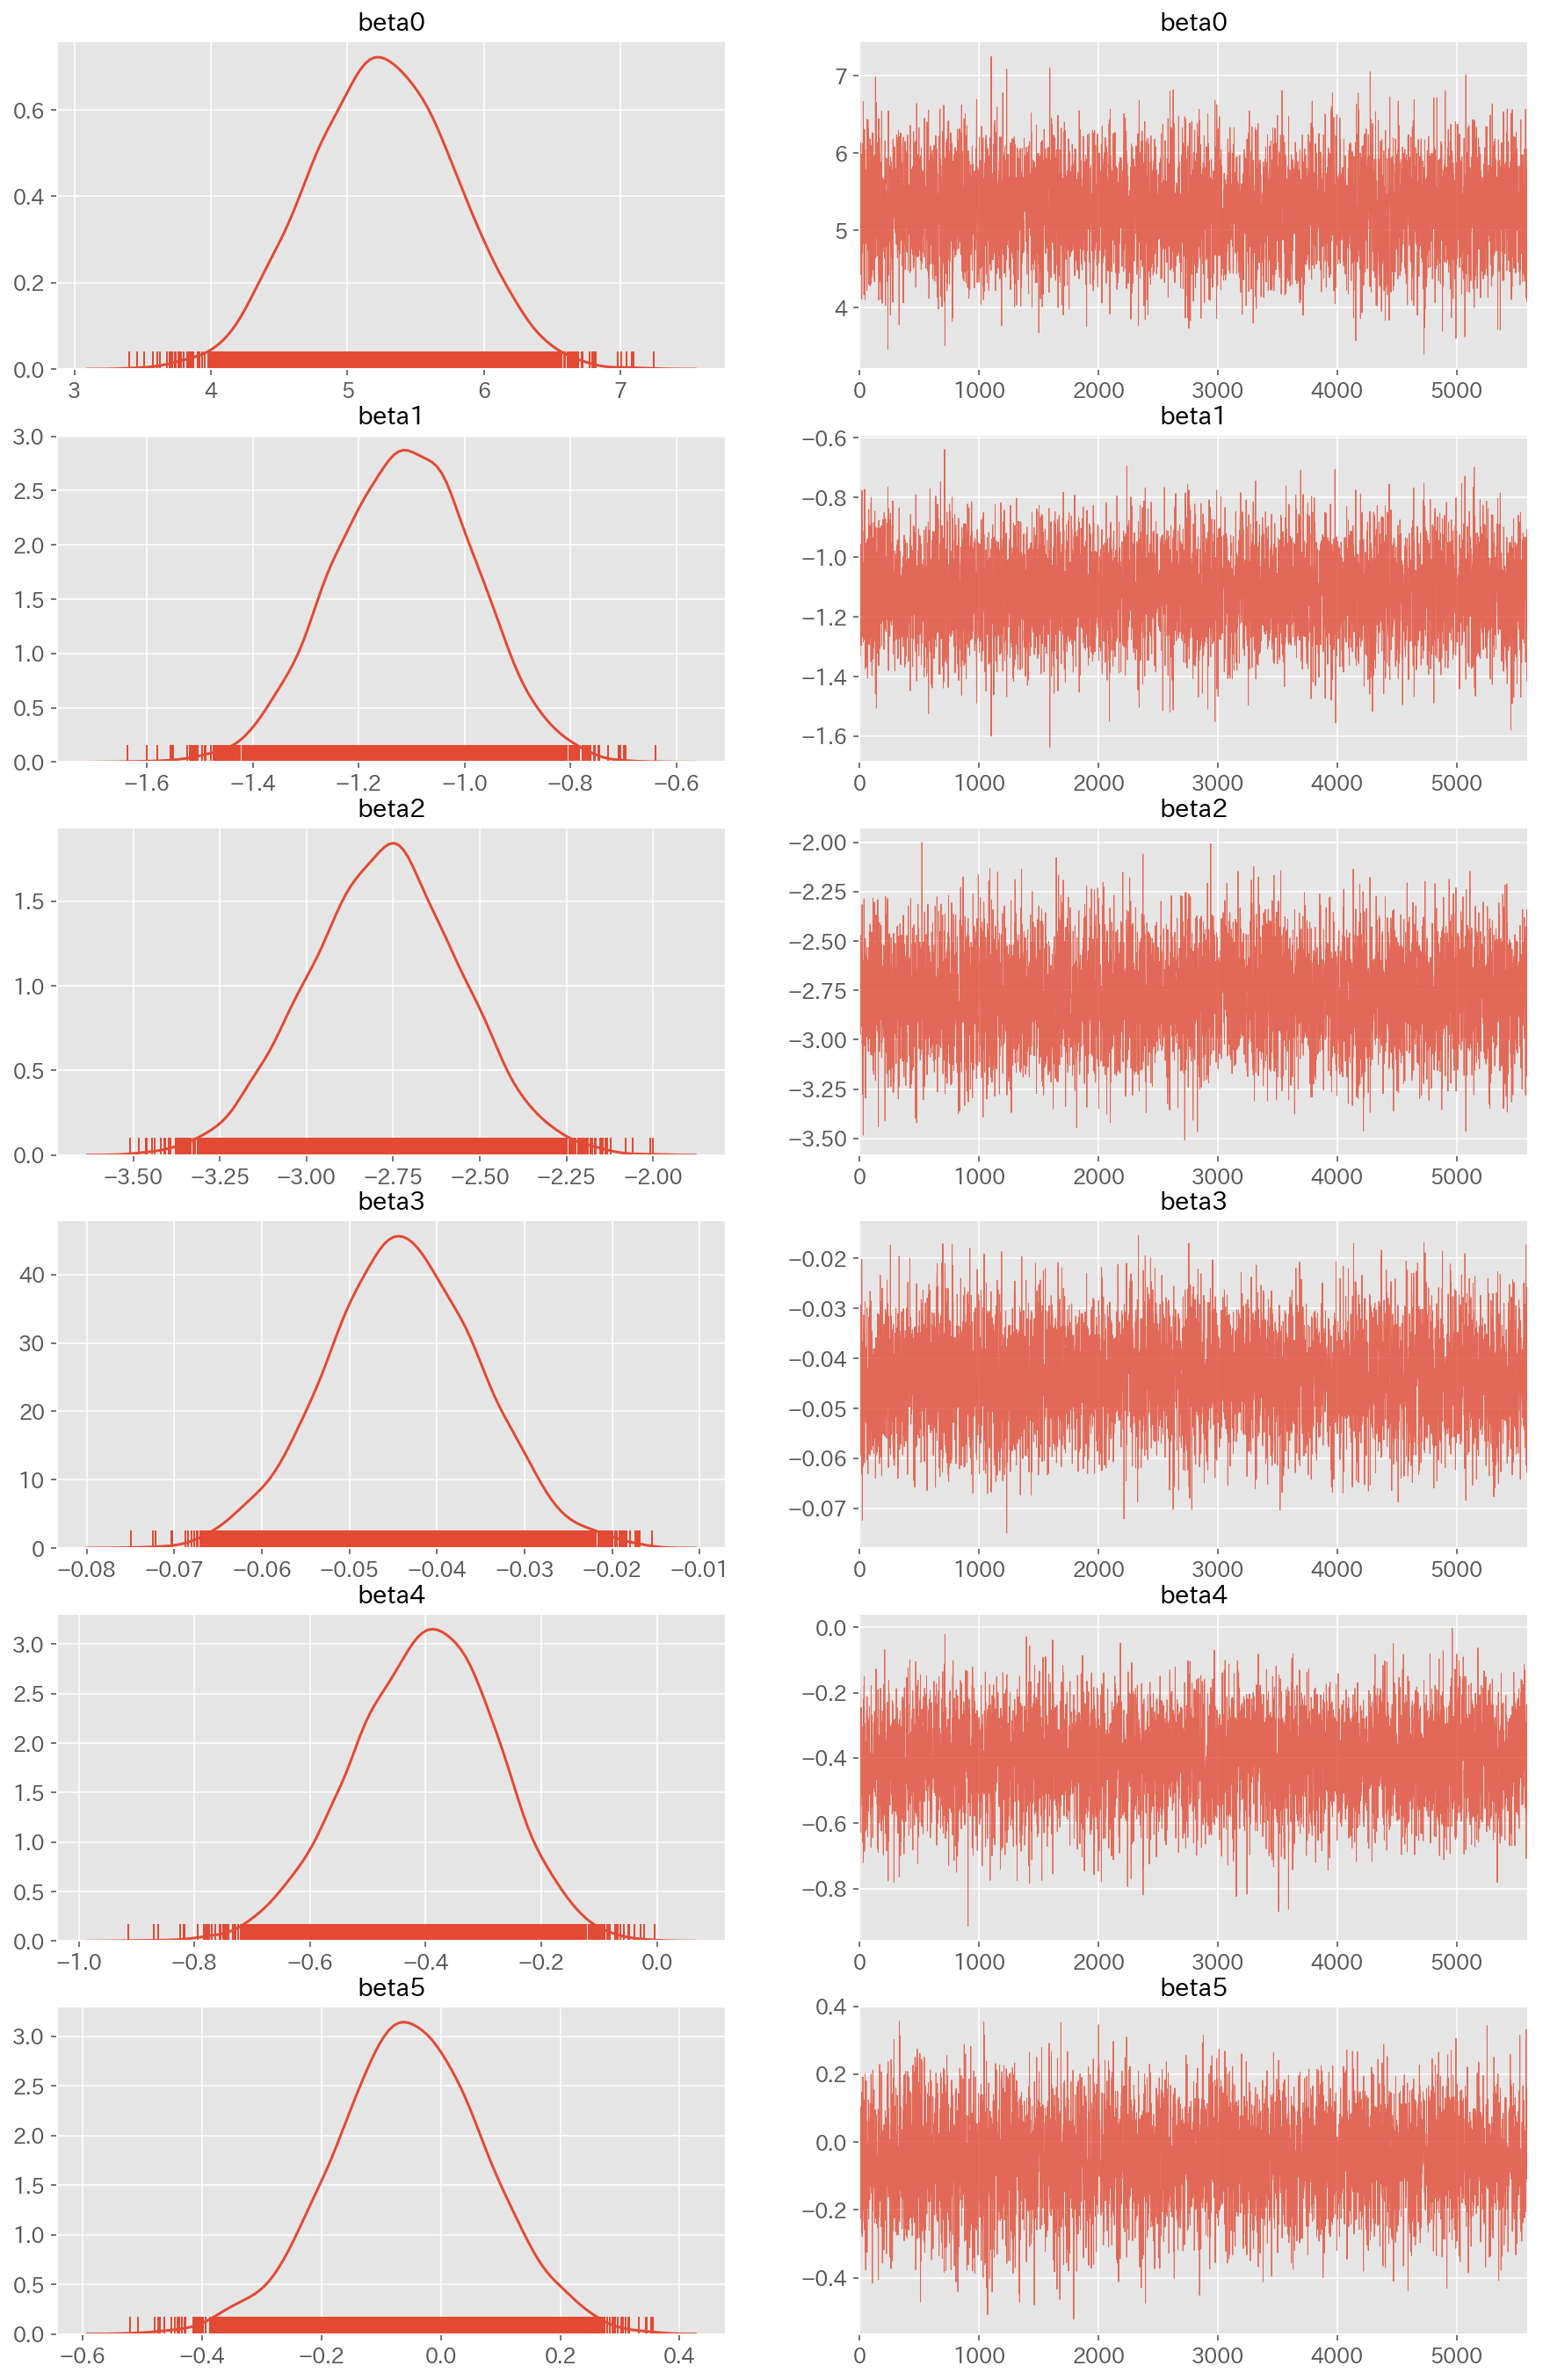

In [12]:
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt = 0
for name in names:
    dat = la[name]
    if dat.ndim == 2:
        for j in range(dat.shape[1]):
            d = dat[:,j]
            sns.distplot(d, hist=False, rug=True, ax=axes[cnt, 0])
            sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    else:
        # Intercept
        sns.distplot(dat, hist=False, rug=True, ax=axes[cnt, 0])
        sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1

name_list = []
for name in names:
    if la[name].ndim == 2:
        for i in range(dat.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()

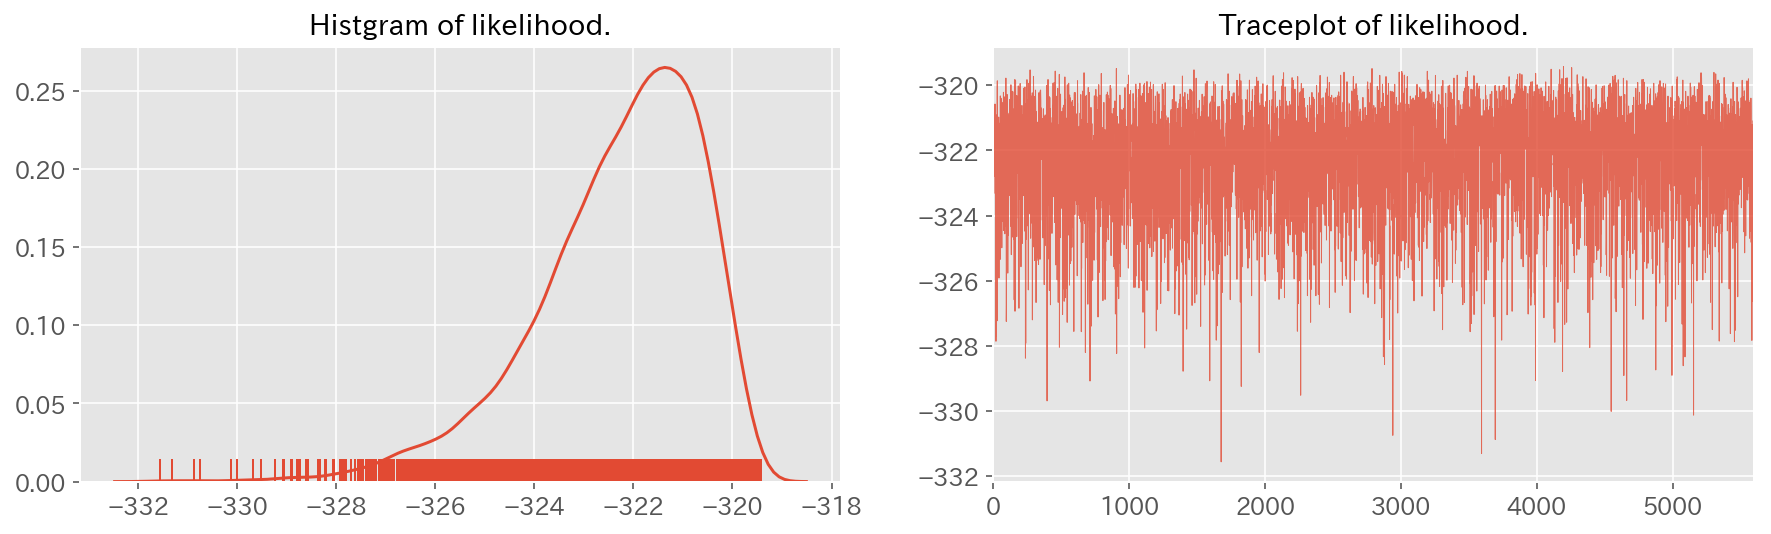

In [13]:
# Likelihood
f, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.distplot(la['lp__'], hist=False, rug=True, ax=axes[0])
sns.tsplot(la['lp__'],   alpha=0.8, lw=.5, ax=axes[1])
axes[0].set_title("Histgram of likelihood.")
axes[1].set_title("Traceplot of likelihood.")
plt.show()


In [14]:
# 推定したパラメータ値を代入して確率p_iを算出するための関数。
def logis(x, beta):
    assert len(beta) == 7
    assert len(beta) == 7
    if type(x) != 'np.array':
        x = np.array(x)
    tmp = [1]
    tmp.extend(x)
    x = tmp
    return (1+np.exp(-np.dot(x, beta)))**(-1)

# 設定された閾値で0 or 1を判定。デフォルト閾値は0.5
def check_accuracy(data, target, param, threshold = 0.5):
    ans_list = []
    for i in range(len(data)):
        idx = data.index[i]
        res = logis(data.ix[idx], param)
        ans = 1 if res > threshold else 0
        ans_list.append(ans == target.ix[idx])

    return np.mean(ans_list)


param = mean_list[0:7]

# 再代入した時の正答率
print (u"[train][EAP] Accuracy:{0:.5f}".format(check_accuracy(X_train, y_train, param)))
print (u"[train][MAP] Accuracy:{0:.5f}".format(check_accuracy(X_train, y_train, MAP_list)))

# テストデータの正答率で汎化性能を見る
print ("[test][EAP] Accuracy:{0:.5f}".format(check_accuracy(X_test, y_test, param)))
print ("[test][MAP] Accuracy:{0:.5f}".format(check_accuracy(X_test, y_test, MAP_list)))

ValueError: shapes (6,) and (7,) not aligned: 6 (dim 0) != 7 (dim 0)